In [1]:
# ---------CASO B: Vuelo rectilíneo y simétrico: T cte y V variable y grande-----------
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from math import pi

import utils
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from mpl_toolkits.mplot3d import Axes3D

## Ecuaciones

- Vuelo rectilíneo, simétrico , alas a nivel no estacionario
- Dos ecuaciones dinámicas, dos incógnitas: V y cl
- Sustiuimos el valor del cl en la ec en eje x y queda una ecuación con una incógnita, la velocidad
- Este caso simula velocidades grandes por lo que los términos 1/v^2 se consideran despreciables
$$
L = W \\
-D + T = m\dot{V} \\
D = \frac{1}{2} \rho_{aire} V^{2} S C_{D0} + k \frac{W^2}{\frac{1}{2} \rho_{aire} V^{2} S} \\
\frac{T}{m} - \frac{1}{2} \rho_{aire} V^{2} \frac{S}{m} C_{D0} - k \frac{g^2}{\frac{1}{2} \rho_{aire} V^{2} \frac{S}{m}} = \dot{V}
$$

Sindy será alimentado con la velocidad adimensionalizada, por tanto las ecuaciones son las siguientes:
$$
\dot{V} = -AV^2 + C \\
\hat{V} = \frac{V}{U_\infty} \\
Por\hspace{0.1cm}tanto:\hspace{0.1cm}
\hat{\dot{V}} = \frac{dV}{dt}\frac{1}{U_\infty} \\
Se\hspace{0.1cm}obtiene:\hspace{0.1cm}
U_\infty \hat{\dot{V}} = -AU_\infty^2\hat{V}^2 + C \\

Despejando:\hspace{0.1cm}
\hat{\dot{V}} = -AU_\infty \hat{V}^2 + \frac{C}{U_\infty}\\
A = \frac{1}{2} \rho_{aire} \frac{S}{m} C_{D0}; C = \frac{T}{m}
$$
Sindy calcula los coeficientes a y c:
$$ a = AU_\infty; c = \frac{C}{U_\infty}\\ $$
$$\hat{\dot{V}} = -a{\hat{V}}^2 + c \\$$

## Variables globales

In [2]:
# definicion de parametros fisicos y aerondinamicos de la aeronave:
# tomado de http://www.aero.us.es/iia/archivos/Problemas/Problemas_MV.pdf
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
T0 = 12 # T/m
A = 0.5*1.225*cd0*S/m
B = k*9.81**2/(0.5*1.225*S/m)
print(f"Valor de los coeficientes: A={A}, C={T0}")


Valor de los coeficientes: A=0.0013505625, C=12


In [3]:
#definición de las variables generales
n = 10000
deltat = 0.001
""" t = np.zeros(n)
for i in range(0, n):
    t[i] = deltat*i

print(t.shape[0], t) """
t = np.arange(0, int(n*deltat), deltat)
N_SIMS = 10


## Funciones

In [4]:
def plot_ntraj(n_trayec, error):
    plt.figure(figsize=(8,6))
    plt.title("Análisis número de trayectorias")
    plt.xlabel('Número de trayectorias')
    plt.ylabel('Error medio de cada simulación por trayectoria')
    error2 = np.mean(error, axis=2)
    plt.semilogy(n_trayec, np.median(error2, axis=0))
    #plt.semilogy(n_trayec, np.median(np.median(error, axis=2), axis=0))

In [5]:
def plot_error_vs_tiempo(t, error, trayecs):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error a lo largo de la trayectoria")
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Mediana del error')

    for i, n in enumerate(trayecs):
        plt.plot(t, np.median(error[:, i, :], axis=0), label=str(n) + ' trayec')
    plt.legend()

In [6]:
def plot_error_vs_tiempo_val(t, error, n_trayec):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error a lo largo de la trayectoria medio")
    plt.xlabel('Tiempo de validacion(s)')
    plt.ylabel('Mediana del error')
    error2 = np.median(error, axis=0)
    for trayec, i in zip(n_trayec, range(len(n_trayec))):
        #print(len(np.median(error, axis=0).squeeze()))
        plt.plot(t, error2[i, :], label=str(trayec)+ ' trayec')
    plt.legend()

In [7]:
def plot_error_vs_pot_ruido(error, n_trayec, pots):
    plt.figure(figsize=(8,6))
    plt.title("Evolución error según pot ruido")
    plt.xlabel('Pot ruido')
    plt.ylabel('Mediana del error')
    error2 = np.median(error, axis=0)
    for trayec, i in zip(n_trayec, range(len(n_trayec))):
        plt.loglog(pots, error2[i, :], label=str(trayec)+ ' trayec')
    plt.legend()

In [8]:
def plot_precision_tiempo(error, tiempos, muestras):
    fig = plt.figure(figsize=(8,6))
    M, T = np.meshgrid(muestras, tiempos)
    
    error2 = error.mean(axis=0)
    
    # ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)

    ax.plot_surface(M, T, error2, cmap="coolwarm")
    ax.set_xlabel('Tiempo máximo de entrenamiento')
    ax.set_ylabel('Número de muestras')
    ax.set_zlabel('Error cuadrático medio')

In [9]:
def plot_precision_tiempo_vs_trayec(error, tiempos, muestras, trayec):
    fig = plt.figure(figsize=(8,6))
    T, M = np.meshgrid(tiempos, muestras)
    
    error2 = error.mean(axis=0)
    
    # ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig)

    for i in range(len(trayec)):
        print(error2[:, :, i].shape)
        print(M.shape, T.shape)
        ax.plot_surface(T, M, error2[:, :, i], cmap="coolwarm", label=str(trayec[i]) + ' trayec')
        #ax.set_label()
        ax.set_xlabel('Tiempo máximo de entrenamiento')
        ax.set_ylabel('Número de muestras')
        ax.set_zlabel('Error cuadrático medio')
        ax.legend()

## Generar gráficas

In [23]:
n_trayectorias_test = [2,4,6,8,10]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0,
                 mod=utils.Model_params(feature_list=['v'], lib=utils.custom_ecs_B()))
        error[j,i] = mod.error_trayec(t)[:, 0]
    if n_trayectorias_test[i] == 10:
        #mod.plot_trayec(t)
        model10 = mod.model_sindy

model10.print(lhs=["v'"])


v = -0.135 v^2 + 0.120 1


v = -0.135 x0^2 + 0.120 1


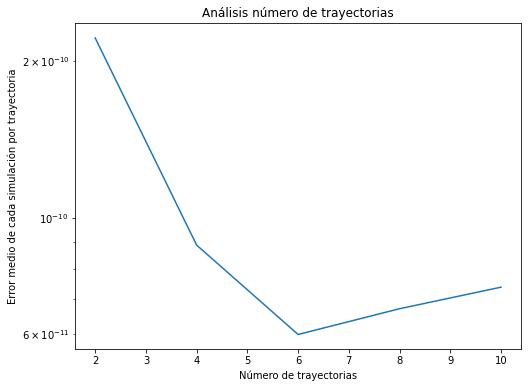

In [20]:
n_trayectorias_test = [2,4,6,8,10]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0)
        error[j,i] = mod.error_trayec(t)[:, 0]
    if n_trayectorias_test[i] == 10:
        #mod.plot_trayec(t)
        model10 = mod.model_sindy

model10.print(lhs=['v'])
# Representar
plot_ntraj(n_trayectorias_test, error)


In [12]:
n_trayectorias_test = [2,4,6,7,8,10,15,17,20]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

t2 = np.arange(0, int(n*3*deltat), deltat)

error2 = np.zeros((n_sims, len(n_trayectorias_test), len_traj)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0)
        error2[j,i] = mod.error_trayec(t)[:, 0]


KeyboardInterrupt: 

array([1.10687261e-10, 3.77382594e-11, 2.28629138e-11, 1.03101073e-11,
       1.06678560e-11])

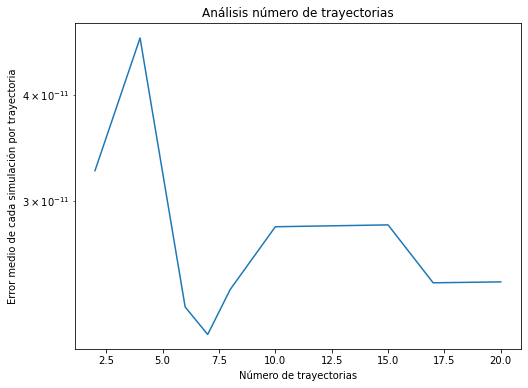

In [27]:
# Representar
plot_ntraj(n_trayectorias_test, error2)
np.std(np.std(error, axis=2), axis=0)

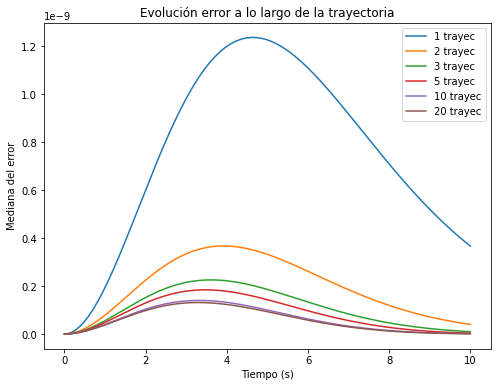

In [23]:
# represento la evoucion del error con el tiempo
n_trayectorias_test = [1, 2, 3, 5, 10, 20]
n_sims = N_SIMS
lent = t.shape[0]
v0 = 5
# t vs error en cada punto
error3 = np.zeros((n_sims, len(n_trayectorias_test), lent)) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0)
        error3[j,i] = mod.error_trayec(t)[:, 0]
 
# Representar
plot_error_vs_tiempo(t, error3, n_trayectorias_test)

(array([-2.0e-10,  0.0e+00,  2.0e-10,  4.0e-10,  6.0e-10,  8.0e-10,
         1.0e-09,  1.2e-09,  1.4e-09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

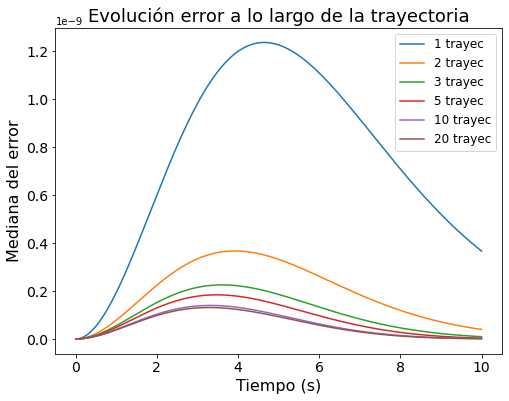

In [24]:
plt.figure(figsize=(8,6))
plt.title("Evolución error a lo largo de la trayectoria", fontsize=18)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Mediana del error', fontsize=16)

for i, n in enumerate(n_trayectorias_test):
    plt.plot(t, np.median(error3[:, i, :], axis=0), label=str(n) + ' trayec')
plt.legend(fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
# entreno con t y calculo el error para tiempos mas grandes
n_trayec = [5, 15, 20, 30]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error4 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoB, n_trayec[i], t, [T0, A, B], v0, t_val=t_val)
            error4[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()



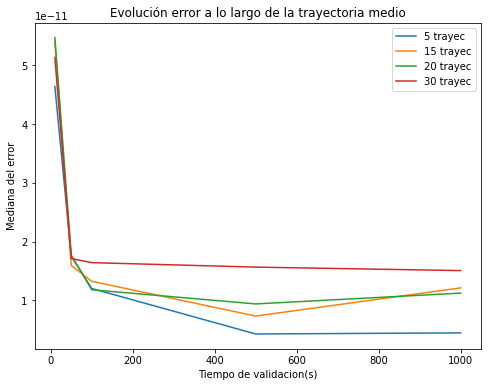

In [ ]:
# Representar tiempo de val vs error
plot_error_vs_tiempo_val(tiempos_val, error4, n_trayec)

In [ ]:
# obtengo el error con ruido en las muestras
n_trayec = [10, 15]
n_sims = N_SIMS
tiempos_val = [10, 50, 100, 500, 1000]
v0 = 5
# t_train vs error en cada punto
error5 = np.zeros((n_sims, len(n_trayec), len(tiempos_val))) # len_Traj no va a ser fijo en la grafica del numero de puntos
for i in range(len(n_trayec)):
    for z in range(len(tiempos_val)):
        t_val = np.arange(0, tiempos_val[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoB, n_trayec[i], t, [T0, A, B], v0, t_val=t_val, ruido=0.1)
            error5[j,i,z] = mod.error_trayec(t_val)[:, 0].mean()



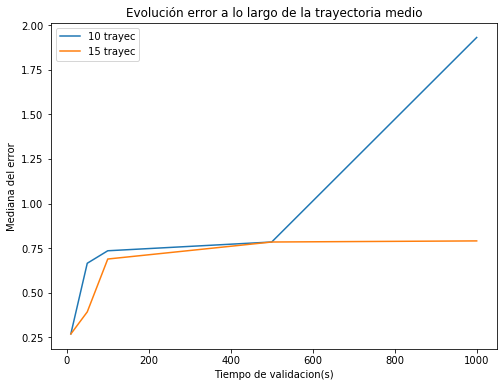

In [ ]:
# Representar tiempo de val vs error con ruido
plot_error_vs_tiempo_val(tiempos_val, error5, n_trayec)

trayectoria número: 5
trayectoria número: 10
trayectoria número: 15
trayectoria número: 20
trayectoria número: 30


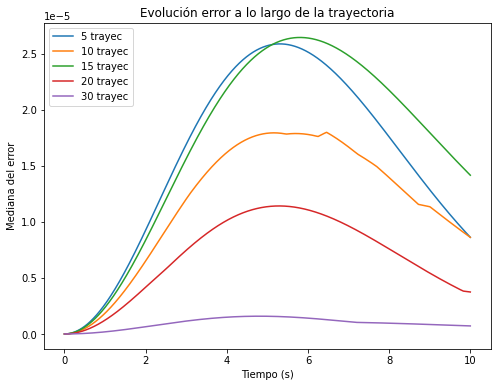

In [29]:
# obtengo el error con ruido en las muestras de train
n_trayec = [5, 10, 15, 20, 30]
n_sims = 15#20
v0 = 5
# t_train vs error en cada punto
error6 = np.zeros((n_sims, len(n_trayec), t.shape[0]))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayec[i], t, [T0, A, B], v0, ruido=0.001)
        error6[j,i] = mod.error_trayec(t)[:, 0]
    print("trayectoria número: "+ str(n_trayec[i]))
    #mod.plot_trayec(t, plot_data_ruidosa=True, ruido=0.001)            
# Representar tiempo de val vs error con ruido 
plot_error_vs_tiempo(t, error6, n_trayec)

(array([-5.0e-06,  0.0e+00,  5.0e-06,  1.0e-05,  1.5e-05,  2.0e-05,
         2.5e-05,  3.0e-05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

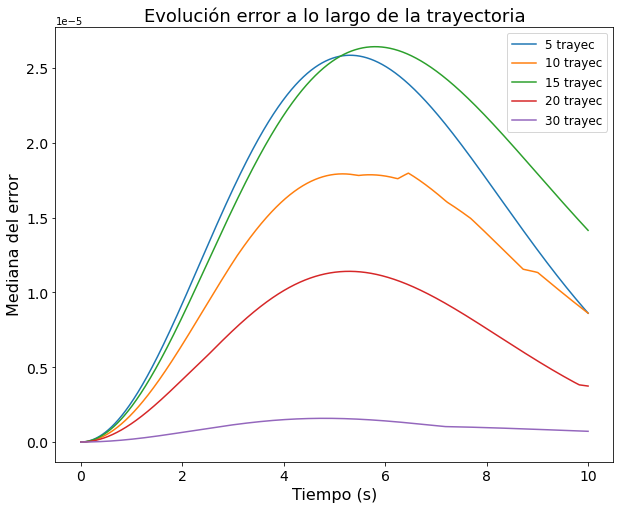

In [30]:
plt.figure(figsize=(10,8))
plt.title("Evolución error a lo largo de la trayectoria", fontsize=18)
plt.xlabel('Tiempo (s)', fontsize=16)
plt.ylabel('Mediana del error', fontsize=16)

for i, n in enumerate(n_trayec):
    plt.plot(t, np.median(error6[:, i, :], axis=0), label=str(n) + ' trayec')
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

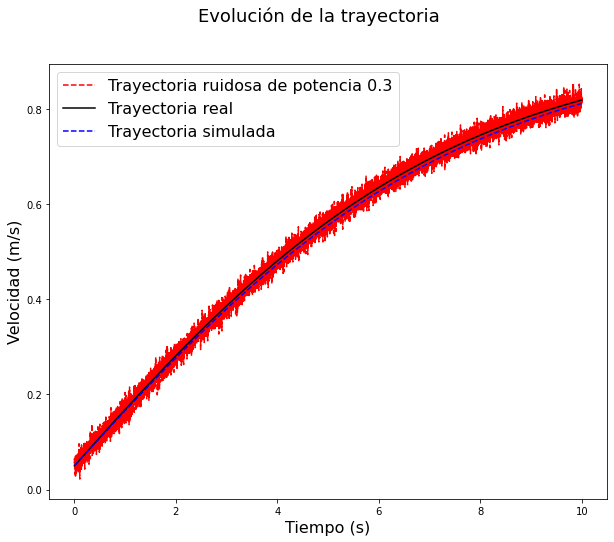

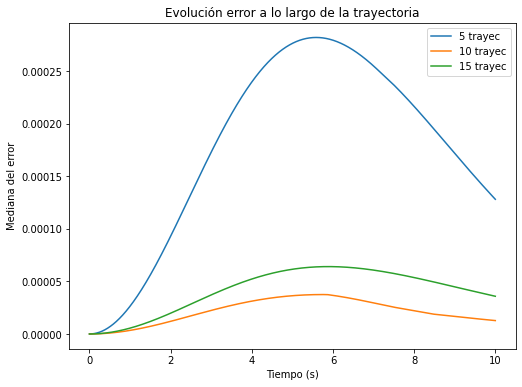

In [10]:
# obtengo el error con ruido en las muestras
n_trayec = [5, 10, 15]
n_sims = N_SIMS
v0 = 5
# t_train vs error en cada punto
error7 = np.zeros((n_sims, len(n_trayec), t.shape[0]))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayec[i], t, [T0, A, B], v0, ruido=0.003)
        error7[j,i,:] = mod.error_trayec(t)[: ,0]
mod.plot_trayec(t, plot_data_ruidosa=True, ruido=0.003)           
# Representar tiempo de val vs error con ruido
plot_error_vs_tiempo(t, error7, n_trayec)

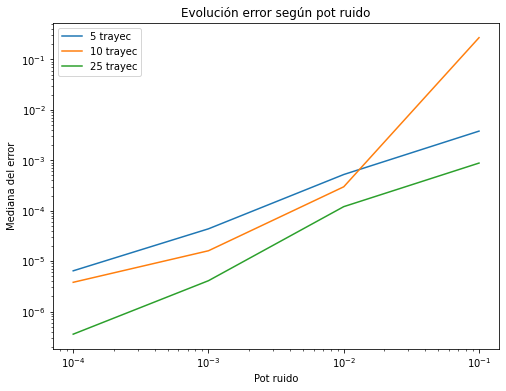

In [18]:
# error vs potencia de ruido en las muestras

n_trayec = [5, 10, 25]
n_sims = N_SIMS
v0 = 5
pots_ruido = [1e-4, 1e-3, 1e-2, 1e-1]
# t_train vs error en cada punto
error8 = np.zeros((n_sims, len(n_trayec), len(pots_ruido)))
for i in range(len(n_trayec)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod = utils.Model()
            mod.eval(utils.casoB, n_trayec[i], t, [T0, A, B], v0, ruido=pots_ruido[z])
            error8[j,i,z] = mod.error_trayec(t)[:, 0].mean()
            
# Representar tiempo de val vs error con ruido
plot_error_vs_pot_ruido(error8, n_trayec, pots_ruido)

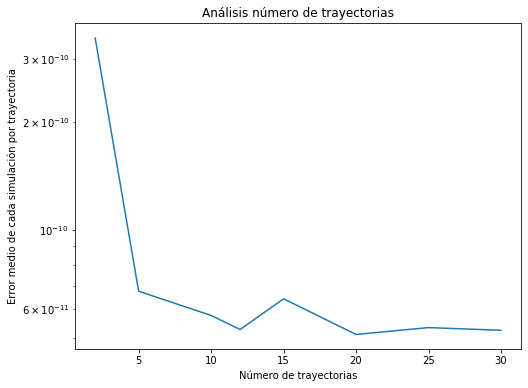

In [ ]:

lib = ps.PolynomialLibrary(degree=2)
n_trayec = [2, 5, 10, 12, 15, 20, 25, 30]
n_sims = N_SIMS
v0 = 5
deltat_train = t[1]-t[0]

errors_pol = []
error_pol = np.zeros((n_sims, len(n_trayec), n))

for i in range(len(n_trayec)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayec[i], t, [T0, A, B], v0,
                                    plot_data_ruidosa=False, mod=utils.Model_params(lib=lib))
        error_pol[j,i, :] = mod.error_trayec(t)[: ,0]
         

            
# Representar tiempo de val vs error con ruido
plot_ntraj(n_trayec, error_pol)


In [13]:
def real_coefs_mat(real_coefs, lib):
    data = [np.ones((n, 1))]
    lib = lib.fit(data[0])
    n_features = lib.n_output_features_
    list_names = lib.get_feature_names(['v'])

    mat = np.zeros((data[0].shape[1], n_features))
    mat[0, list_names.index('v^2')] = real_coefs[0]
    mat[0, list_names.index('1')] = real_coefs[2]

    return mat


In [11]:
# error en los coeficientes según el número de trayectorias:
n_trayectorias_test = [2,4,6,8,10,13, 15, 20]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error10 = np.zeros((n_sims, len(n_trayectorias_test)))
error11 = np.zeros((n_sims, len(n_trayectorias_test)))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0)
        real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
        mat = real_coefs_mat(real_coefs, utils.custom_ecs_B())
        error10[j,i] = np.mean(mod.error_coefs(real_coefs.T)**2, axis=1)
        error11[j,i] = mod.error_trayec(t).mean(axis=0)


<ipython-input-11-c3d2ec82ea7c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
<ipython-input-11-c3d2ec82ea7c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
<ipython-input-11-c3d2ec82ea7c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

[1.50032725e-10 4.49352993e-11 5.02776651e-11 5.83287492e-11
 5.13709089e-11 4.43655543e-11 4.84926604e-11 4.19881799e-11]


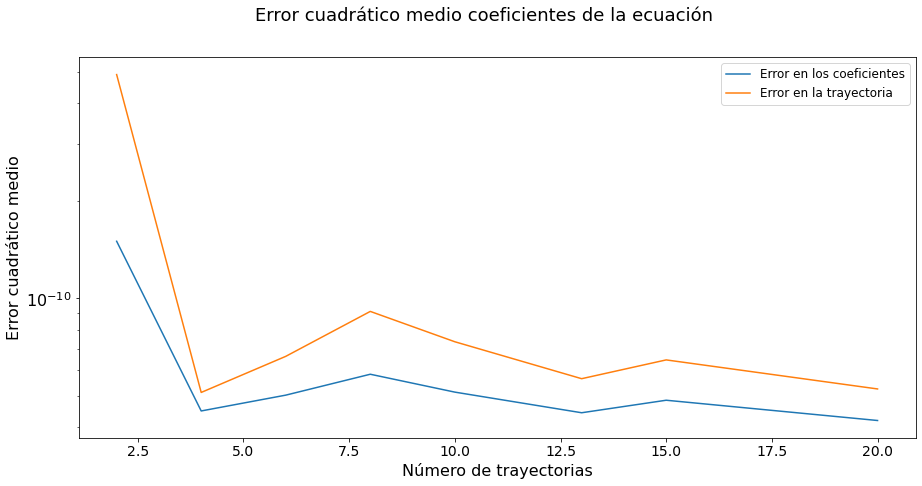

In [13]:
print(np.median(error10, axis=0))
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Error cuadrático medio de coeficientes y trayectoria', fontsize=18)

#print(len(n_trayectorias_test), np.median(error10, axis=0).shape)
plt.semilogy(n_trayectorias_test, np.median(error10, axis=0), label='Error en los coeficientes')
plt.semilogy(n_trayectorias_test, np.median(error11, axis=0), label='Error en la trayectoria')
plt.xlabel('Número de trayectorias', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
plt.xticks(fontsize=14) #n_trayectorias_test, [str(x) for x in n_trayectorias_test], 
plt.yticks(fontsize=16)
plt.legend(fontsize=12)

In [26]:
# error en los coeficientes cambiando la librería: polinomial de grado 5
n_trayectorias_test = [2,4,6,8,10,13, 15, 20]
n_sims = N_SIMS
len_traj = t.shape[0]
v0 = 5

error12 = np.zeros((n_sims, len(n_trayectorias_test)))
error13 = np.zeros((n_sims, len(n_trayectorias_test)))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        mod = utils.Model()
        mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0, 
                    mod=utils.Model_params(lib=ps.PolynomialLibrary(degree=5)))
        real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
        mat = real_coefs_mat(real_coefs, ps.PolynomialLibrary(degree=5))
        error12[j,i] = np.mean(mod.error_coefs(mat)**2, axis=1)
        error13[j,i] = mod.error_trayec(t).mean(axis=0)


<ipython-input-26-77820b57ba2e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
<ipython-input-26-77820b57ba2e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
<ipython-input-26-77820b57ba2e>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

[0. 0. 0. 0. 0. 0. 0. 0.]


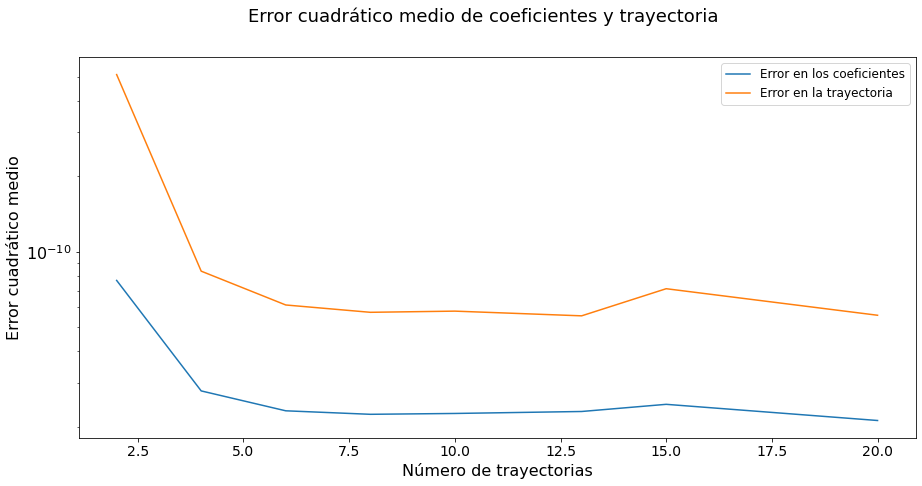

In [27]:
print(np.median(error10, axis=0))
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Error cuadrático medio de coeficientes y trayectoria', fontsize=18)

#print(len(n_trayectorias_test), np.median(error10, axis=0).shape)
plt.semilogy(n_trayectorias_test, np.median(error12, axis=0), label='Error en los coeficientes')
plt.semilogy(n_trayectorias_test, np.median(error13, axis=0), label='Error en la trayectoria')
plt.xlabel('Número de trayectorias', fontsize=16)
plt.ylabel('Error cuadrático medio', fontsize=16)
plt.xticks(fontsize=14) #n_trayectorias_test, [str(x) for x in n_trayectorias_test], 
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

In [ ]:
# calculo el error según el tamaño de t de train y el numero de muestras
n_sims = N_SIMS
tiempos_train = [10, 50, 100, 500, 1000]
muestras = [10**4, 10**5, 10**6]
v0 = 5

trayec = 10
# t_train vs error en cada punto
error9 = np.zeros((n_sims, len(muestras), len(tiempos_train)))
for i in range(len(muestras)):
    for z in range(len(tiempos_train)):
        t_train = np.arange(0, tiempos_train[z], deltat)
        for j in range(n_sims):
            mod = utils.Model()
            mod.eval(utils.casoB, trayec, t_train, [T0, A, B], v0)
            error9[j,i,z] = mod.error_trayec(t_train)[:, 0].mean()

<ipython-input-16-23ab92779db7>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


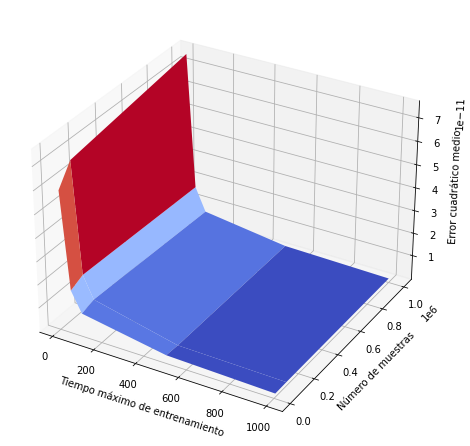

In [ ]:
plot_precision_tiempo(error9, tiempos_train, muestras)

In [33]:
# error vs potencia de ruido en las muestras

n_trayectorias_test = [5, 10, 25]
n_sims = N_SIMS
v0 = 5
pots_ruido = [1e-4, 1e-3, 1e-2, 1e-1]

error14 = np.zeros((n_sims, len(n_trayectorias_test), len(pots_ruido)))
for i in range(len(n_trayectorias_test)):
    for j in range(n_sims):
        for z in range(len(pots_ruido)):
            mod = utils.Model()
            mod.eval(utils.casoB, n_trayectorias_test[i], t, [T0, A, B], v0, ruido=pots_ruido[z])
            real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
            mat = real_coefs_mat(real_coefs, utils.custom_ecs_B())
            error14[j,i, z] = np.mean(mod.error_coefs(real_coefs.T)**2)

<ipython-input-33-d19f7a78ece0>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
<ipython-input-33-d19f7a78ece0>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  real_coefs = np.array([-A*mod.maxi, 0, T0/mod.maxi])
<ipython-input-33-d19f7a78ece0>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

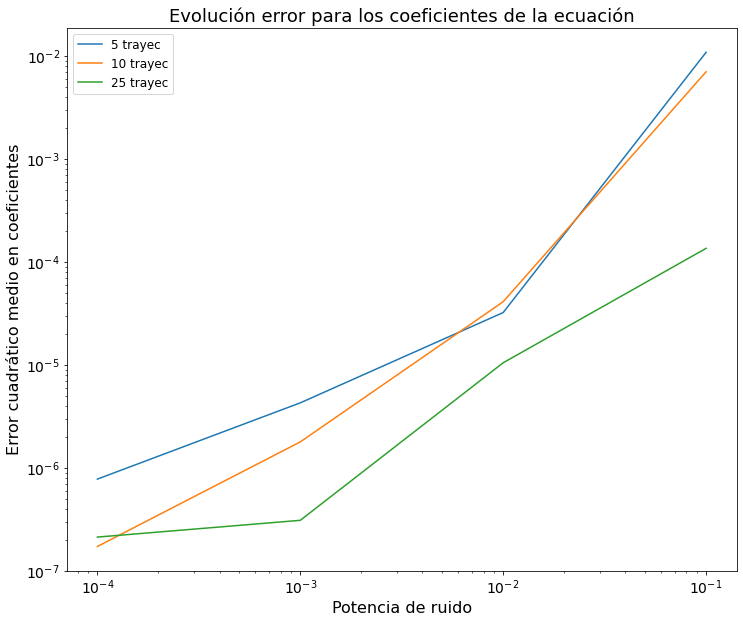

In [34]:
plt.figure(figsize=(12,10))
plt.title("Evolución error para los coeficientes de la ecuación", fontsize=18)
plt.xlabel('Potencia de ruido', fontsize=16)
plt.ylabel('Error cuadrático medio en coeficientes', fontsize=16)
error14_1 = np.median(error14, axis=0)
for trayec, i in zip(n_trayectorias_test, range(len(n_trayectorias_test))):
    plt.loglog(pots_ruido, error14_1[i, :], label=str(trayec)+ ' trayec')
    
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)
plt.legend(fontsize=12)